In [1]:
from liblet import ANTLR, Tree, Stack, AnnotatedTreeWalker

In [2]:
# il punto di questa cella è importare simpleBlock2ast

from contextlib import redirect_stdout

import nbimporter
nbimporter.options['only_defs'] = False

with redirect_stdout(None):
    from L22 import SimpleBlockLang, simpleBlock2ast

# Un interprete ricorsivo

In [3]:
source = """
var prodotto = 1;
var n = 0;
if INPUT0 == 3 then
    OUTPUT = 1;
else {
    repeat INPUT0 times {
        n = n + 1;
        prodotto = prodotto * n;
    }
    OUTPUT = prodotto;
}
"""

In [4]:
@simpleBlock2ast.register
def prodExpr(visit, atree):
    left, _, right = atree.children
    return Tree({'type': 'binOpExpr', 'op': '*'}, [visit(left), visit(right)])

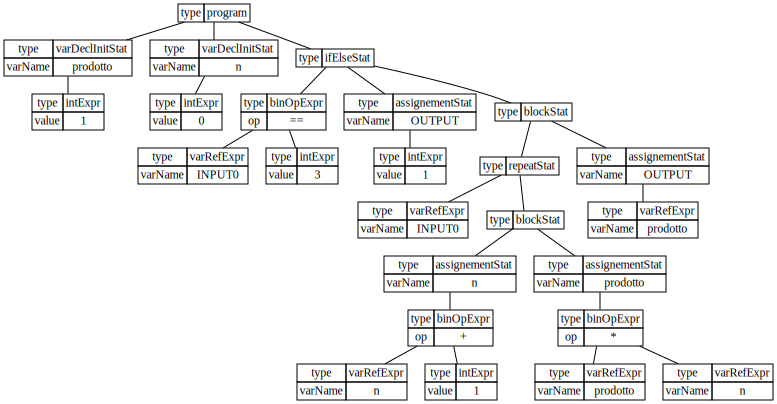

In [5]:
ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))
ast

In [6]:
interpreter = AnnotatedTreeWalker('type')

@interpreter.register
def program(visit, ast):
    for stat in ast.children: visit(stat)
    return interpreter.GLOBAL_MEMORY['OUTPUT']

@interpreter.register
def blockStat(visit, ast):
    for stat in ast.children: visit(stat)
        
@interpreter.register
def varDeclInitStat(visit, ast):
    interpreter.GLOBAL_MEMORY[ast.root['varName']] = visit(ast.children[0])
    
@interpreter.register
def assignementStat(visit, ast):
    interpreter.GLOBAL_MEMORY[ast.root['varName']] = visit(ast.children[0])
    
@interpreter.register
def ifStat(visit, ast):
    cond, stat = ast.children
    if visit(cond): visit(stat)
        
@interpreter.register
def ifElseStat(visit, ast):
    cond, true, false = ast.children
    if visit(cond): 
        visit(true)
    else:
        visit(false)
        
@interpreter.register
def repeatStat(visit, ast):
    count, stat = ast.children
    count = visit(count)
    for _ in range(count): visit(stat)
        
@interpreter.register
def varRefExpr(visit, ast):
    return interpreter.GLOBAL_MEMORY[ast.root['varName']]

@interpreter.register
def binOpExpr(visit, ast):
    left = visit(ast.children[0])
    right = visit(ast.children[1])
    if ast.root['op'] == '*':
        return left * right
    elif ast.root['op'] == '+':
        return left + right
    elif ast.root['op'] == '-':
        return left - right
    elif ast.root['op'] == '==':
        return left == right
    
@interpreter.register
def intExpr(visit, ast):
    return ast.root['value']

In [7]:
interpreter.GLOBAL_MEMORY = {'INPUT0': 6}        
interpreter(ast)

720

In [8]:
interpreter.GLOBAL_MEMORY = {'INPUT0': 3}        
interpreter(ast)

1

# E le funzioni?

In [9]:
SimpleFuncLang = ANTLR(r"""grammar SimpleBlockLang;

program: functionDecl+ ;

functionDecl: 'function' ID '(' formalParameters? ')' block ;
formalParameters: ID (',' ID)* ;

block: '{' stat* '}' ;

expr: ID '(' exprList? ')' #funcCallExpr
    | '!' expr #notExpr
    | expr '*' expr #prodExpr
    | expr ('+'|'-') expr #addSubExpr
    | expr '==' expr #equalityExpr
    | ID #varRefExpr
    | INT #intExpr
    | '(' expr ')' #subExpr
    ;

exprList: expr (',' expr)* ;

stat: block #blockStat
    | 'var' ID ('=' expr)? ';' #varDeclStat
    | 'if' expr 'then' stat ('else' stat)? #ifElseStat
    | 'repeat' expr 'times' stat #repeatStat
    | 'return' expr? ';' #returnStat
    | ID '=' expr ';' #assignementStat
    | expr ';' #exprStat
    ;


ID: LETTER (LETTER | [0-9])* ;
INT: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
fragment
LETTER : [a-zA-Z] ;
""")

In [10]:
source = r"""
function fact(n) {
    if n == 0 then
        return 1;
    else
        return n * fact(n - 1);
}

function main() {
    OUTPUT = fact(INPUT0);
}
"""

In [11]:
@simpleBlock2ast.register
def functionDecl(visit, atree):
    if len(atree.children) == 6:
        _, name, _, params, _, block = atree.children
    else:
        _, name, _, _, block = atree.children
        params = []
    block = Tree({'type': 'blockStat'}, [visit(stat) for stat in block.children[1:-1]])
    params = [param.root['value'] for param in params.children[::2]] if params else []
    return Tree({'type': 'functionDecl', 'funcName': name.root['value'], 'params': params}, [block])

@simpleBlock2ast.register
def funcCallExpr(visit, atree):
    if len(atree.children) == 4:
        func, _, args, _ = atree.children
        args = args.children[::2]
    else:
        func, _, _ = atree.children
        args = []
    return Tree({'type': 'funcCallExpr', 'funcName': func.root['value']}, [visit(arg) for arg in args])

@simpleBlock2ast.register
def returnStat(visit, atree):
    if len(atree.children) == 3:
        _, expr, _ = atree.children
        return Tree({'type': 'returnStat'}, [visit(expr)])
    else:
        return Tree({'type': 'returnStat'})
    
@simpleBlock2ast.register
def exprStat(visit, atree):
    return Tree({'type': 'exprStat'}, [visit(atree.children[0])])

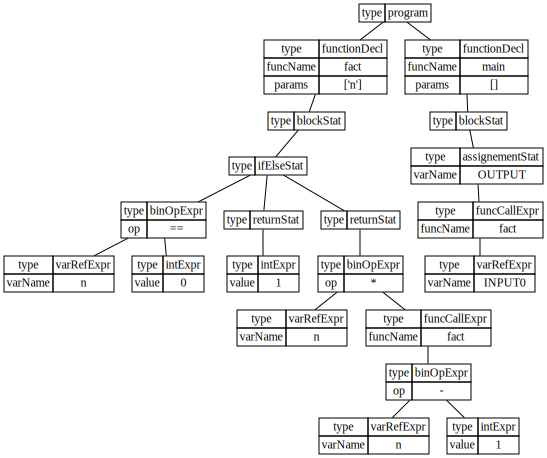

In [12]:
ast = simpleBlock2ast(SimpleFuncLang.tree(source, 'program'))
ast

In [13]:
@interpreter.register
def functionDecl(visit, ast):
    visit(ast.children[0])

@interpreter.register
def varRefExpr(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    return local_memory[ast.root['varName']]
    
@interpreter.register
def varDeclInitStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    local_memory[ast.root['varName']] = visit(ast.children[0])
    
@interpreter.register
def assignementStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    local_memory[ast.root['varName']] = visit(ast.children[0])

@interpreter.register
def program(visit, ast):
    interpreter.FUNCTIONS = {func.root['funcName']: func for func in ast.children}
    visit(interpreter.FUNCTIONS['main'])
    return interpreter.ACTIVATION_RECORDS.pop()['OUTPUT']

In [14]:
@interpreter.register
def funcCallExpr(visit, ast):
    function = interpreter.FUNCTIONS[ast.root['funcName']]
    interpreter.ACTIVATION_RECORDS.push(dict(zip(
        function.root['params'],
        [visit(arg) for arg in ast.children]
    )))
    visit(function)
    return interpreter.ACTIVATION_RECORDS.pop()['_retval']

@interpreter.register
def returnStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    local_memory['_retval'] = visit(ast.children[0]) if ast.children else None

In [15]:
interpreter.ACTIVATION_RECORDS = Stack([{'INPUT0': 6}])
interpreter(ast)

720

In [16]:
source = r"""
function fib(n) {
    if n == 1 then
        return 1;
    else if n == 2 then
        return 1;
    else 
        return fib(n-1) + fib(n-2);
}

function main() {
    OUTPUT = fib(INPUT0);
}
"""

In [17]:
ast = simpleBlock2ast(SimpleFuncLang.tree(source, 'program'))
interpreter.ACTIVATION_RECORDS = Stack([{'INPUT0': 11}])
interpreter(ast)

89

## Ma return non interrompe!

In [18]:
source = r"""
function noret(n) {
    var somma = 0;
    var n = 0;
    repeat 10 times {
        return 1;
        n = n + 1;
        somma = somma + n;
    }
    return somma;
}

function main() {
    OUTPUT = noret(INPUT0);
}
"""

In [19]:
ast = simpleBlock2ast(SimpleFuncLang.tree(source, 'program'))
interpreter.ACTIVATION_RECORDS = Stack([{'INPUT0': 11}])
interpreter(ast)

55

In [20]:
@interpreter.register
def blockStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    for stat in ast.children: 
        if '_retval' in local_memory: return
        visit(stat)

@interpreter.register
def repeatStat(visit, ast):
    local_memory = interpreter.ACTIVATION_RECORDS.peek()
    count, stat = ast.children
    count = visit(count)
    for _ in range(count): 
        if '_retval' in local_memory: return
        visit(stat)        

In [21]:
ast = simpleBlock2ast(SimpleFuncLang.tree(source, 'program'))
interpreter.ACTIVATION_RECORDS = Stack([{'INPUT0': 11}])
interpreter(ast)

1